In [35]:
import atd2022
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import my_mod as util
import importlib
importlib.reload(util)

<module 'my_mod' from 'C:\\Users\\Work Space\\atd2022\\code\\my_mod.py'>

In [2]:
pd.options.display.max_columns = None

# 1-dim CNN experiment on 20-dim time series vector

# Data Import/Preprocessing

In [3]:
data = atd2022.io.read_csv()

In [4]:
test_region=data["AA"]

In [16]:
len(test_region)

215

In [98]:
test_region.tail(6)

Event,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20
2018-01-01/2018-01-07,7,5,26,22,5,0,0,1,1,0,3,1,0,0,0,0,1,0,0,0
2018-01-08/2018-01-14,13,9,20,85,4,2,0,2,8,0,0,0,0,0,0,1,8,0,0,0
2018-01-15/2018-01-21,14,5,8,10,1,0,0,1,0,1,0,1,0,0,0,0,3,0,2,0
2018-01-22/2018-01-28,5,2,0,23,3,2,5,1,0,0,2,0,0,0,0,3,4,0,4,0
2018-01-29/2018-02-04,3,2,7,37,6,10,4,7,0,1,1,1,0,0,0,0,0,0,0,0
2018-02-05/2018-02-11,7,6,7,49,6,0,1,2,2,2,6,0,1,0,0,0,2,0,4,0


In [30]:
test=util.getMultiDXY(test_region, n_lags=2)

(20,)


In [31]:
test

array([[0., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       [0., 1., 3., ..., 0., 1., 0.],
       ...,
       [5., 2., 0., ..., 0., 4., 0.],
       [3., 2., 7., ..., 0., 0., 0.],
       [7., 6., 7., ..., 0., 4., 0.]])

In [32]:
test[2,:]

array([0., 1., 3., 7., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0.])

In [36]:
x,y = util.getMultiDXY(test_region, n_lags=2)

In [37]:
x

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 2.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 2.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  3., ...,  0.,  1.,  0.]],

       [[ 0.,  1.,  3., ...,  0.,  1.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.]],

       ...,

       [[13.,  9., 20., ...,  0.,  0.,  0.],
        [14.,  5.,  8., ...,  0.,  2.,  0.]],

       [[14.,  5.,  8., ...,  0.,  2.,  0.],
        [ 5.,  2.,  0., ...,  0.,  4.,  0.]],

       [[ 5.,  2.,  0., ...,  0.,  4.,  0.],
        [ 3.,  2.,  7., ...,  0.,  0.,  0.]]])

In [38]:
y

array([[ 0.,  1.,  3., ...,  0.,  1.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 6.,  1., 59., ...,  0.,  0.,  0.],
       ...,
       [ 5.,  2.,  0., ...,  0.,  4.,  0.],
       [ 3.,  2.,  7., ...,  0.,  0.,  0.],
       [ 7.,  6.,  7., ...,  0.,  4.,  0.]])

In [39]:
y.shape

(213, 20)

In [40]:
x.shape

(213, 2, 20)

In [46]:
# (#of samples, timesteps, #features(i.e. number of parallel time series))

In [43]:
n_features = 20
x_train=x.reshape((x.shape[0], x.shape[1], n_features))

In [45]:
x_train.shape

(213, 2, 20)

In [44]:
y_train=y

# CNN Model Building

In [79]:
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
import gc
device=torch.device("cpu")

In [103]:
class CNN_ForecastNet(nn.Module):
    def __init__(self):
        super(CNN_ForecastNet,self).__init__()
        self.conv1d = nn.Conv1d(2,128,kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(128,64)
        self.fc2 = nn.Linear(64,1)
        
    def forward(self,x):
        x = self.conv1d(x)
        x = self.relu(x)
        #print(x.shape)
        x = x.view(-1,128)
        #print(x.shape)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [104]:
model = CNN_ForecastNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [105]:
class myDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label

In [106]:
train = myDataset(x_train,y_train)
train_loader = torch.utils.data.DataLoader(train,batch_size=1,shuffle=False)

In [107]:
train_losses = []
valid_losses = []
def Train():
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs=inputs.to(torch.float32)
        labels=labels.to(torch.float32)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().numpy())
    
    print(f'train_loss {train_loss}')

def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss.detach().numpy())
        print(f'valid_loss {valid_loss}')

In [159]:
epochs = 1000
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train()
    #Valid()
    gc.collect()

epochs 1/1000


C:\Users\Work Space\anaconda3\envs\atd2022\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1, 20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


train_loss 89.11209106445312
epochs 2/1000
train_loss 89.10184478759766
epochs 3/1000
train_loss 89.09126281738281
epochs 4/1000
train_loss 89.0811767578125
epochs 5/1000
train_loss 89.0707778930664
epochs 6/1000
train_loss 89.06046295166016
epochs 7/1000
train_loss 89.050537109375
epochs 8/1000
train_loss 89.04032135009766
epochs 9/1000
train_loss 89.03024291992188
epochs 10/1000
train_loss 89.020263671875
epochs 11/1000
train_loss 89.01031494140625
epochs 12/1000
train_loss 89.00037384033203
epochs 13/1000
train_loss 88.99047088623047
epochs 14/1000
train_loss 88.98054504394531
epochs 15/1000
train_loss 88.9708023071289
epochs 16/1000
train_loss 88.96112823486328
epochs 17/1000
train_loss 88.95130920410156
epochs 18/1000
train_loss 88.94168090820312
epochs 19/1000
train_loss 88.93201446533203
epochs 20/1000
train_loss 88.92237854003906
epochs 21/1000
train_loss 88.912841796875
epochs 22/1000
train_loss 88.90332794189453
epochs 23/1000
train_loss 88.89389038085938
epochs 24/1000
train

train_loss 87.75202941894531
epochs 188/1000
train_loss 87.74685668945312
epochs 189/1000
train_loss 87.74173736572266
epochs 190/1000
train_loss 87.73660278320312
epochs 191/1000
train_loss 87.73138427734375
epochs 192/1000
train_loss 87.72643280029297
epochs 193/1000
train_loss 87.7212905883789
epochs 194/1000
train_loss 87.71623992919922
epochs 195/1000
train_loss 87.71111297607422
epochs 196/1000
train_loss 87.70604705810547
epochs 197/1000
train_loss 87.7010269165039
epochs 198/1000
train_loss 87.69593811035156
epochs 199/1000
train_loss 87.69097900390625
epochs 200/1000
train_loss 87.68598937988281
epochs 201/1000
train_loss 87.68102264404297
epochs 202/1000
train_loss 87.67601013183594
epochs 203/1000
train_loss 87.67105865478516
epochs 204/1000
train_loss 87.66614532470703
epochs 205/1000
train_loss 87.66119384765625
epochs 206/1000
train_loss 87.65631103515625
epochs 207/1000
train_loss 87.65145111083984
epochs 208/1000
train_loss 87.64656066894531
epochs 209/1000
train_loss 8

train_loss 87.0031967163086
epochs 371/1000
train_loss 86.9998550415039
epochs 372/1000
train_loss 86.99651336669922
epochs 373/1000
train_loss 86.99321746826172
epochs 374/1000
train_loss 86.98985290527344
epochs 375/1000
train_loss 86.986572265625
epochs 376/1000
train_loss 86.9832992553711
epochs 377/1000
train_loss 86.98009490966797
epochs 378/1000
train_loss 86.97673797607422
epochs 379/1000
train_loss 86.97345733642578
epochs 380/1000
train_loss 86.97023010253906
epochs 381/1000
train_loss 86.96698760986328
epochs 382/1000
train_loss 86.96363067626953
epochs 383/1000
train_loss 86.96055603027344
epochs 384/1000
train_loss 86.95716857910156
epochs 385/1000
train_loss 86.95397186279297
epochs 386/1000
train_loss 86.95075988769531
epochs 387/1000
train_loss 86.94745635986328
epochs 388/1000
train_loss 86.94432830810547
epochs 389/1000
train_loss 86.94110107421875
epochs 390/1000
train_loss 86.93771362304688
epochs 391/1000
train_loss 86.93453979492188
epochs 392/1000
train_loss 86.9

train_loss 86.45870971679688
epochs 555/1000
train_loss 86.45611572265625
epochs 556/1000
train_loss 86.45336151123047
epochs 557/1000
train_loss 86.45084381103516
epochs 558/1000
train_loss 86.4482192993164
epochs 559/1000
train_loss 86.44564056396484
epochs 560/1000
train_loss 86.44293975830078
epochs 561/1000
train_loss 86.44037628173828
epochs 562/1000
train_loss 86.43771362304688
epochs 563/1000
train_loss 86.4350814819336
epochs 564/1000
train_loss 86.43248748779297
epochs 565/1000
train_loss 86.42977142333984
epochs 566/1000
train_loss 86.42723846435547
epochs 567/1000
train_loss 86.4245376586914
epochs 568/1000
train_loss 86.42195892333984
epochs 569/1000
train_loss 86.41928100585938
epochs 570/1000
train_loss 86.41666412353516
epochs 571/1000
train_loss 86.41402435302734
epochs 572/1000
train_loss 86.4113998413086
epochs 573/1000
train_loss 86.40875244140625
epochs 574/1000
train_loss 86.4061050415039
epochs 575/1000
train_loss 86.40364837646484
epochs 576/1000
train_loss 86.4

train_loss 86.01038360595703
epochs 738/1000
train_loss 86.0080795288086
epochs 739/1000
train_loss 86.00584411621094
epochs 740/1000
train_loss 86.00357818603516
epochs 741/1000
train_loss 86.00128173828125
epochs 742/1000
train_loss 85.99895477294922
epochs 743/1000
train_loss 85.99678039550781
epochs 744/1000
train_loss 85.99440002441406
epochs 745/1000
train_loss 85.99223327636719
epochs 746/1000
train_loss 85.98987579345703
epochs 747/1000
train_loss 85.98764038085938
epochs 748/1000
train_loss 85.9853286743164
epochs 749/1000
train_loss 85.98311614990234
epochs 750/1000
train_loss 85.98074340820312
epochs 751/1000
train_loss 85.97856140136719
epochs 752/1000
train_loss 85.97634887695312
epochs 753/1000
train_loss 85.97403717041016
epochs 754/1000
train_loss 85.97173309326172
epochs 755/1000
train_loss 85.969482421875
epochs 756/1000
train_loss 85.96717071533203
epochs 757/1000
train_loss 85.9649887084961
epochs 758/1000
train_loss 85.96269226074219
epochs 759/1000
train_loss 85.9

train_loss 85.6157455444336
epochs 922/1000
train_loss 85.61373901367188
epochs 923/1000
train_loss 85.61170959472656
epochs 924/1000
train_loss 85.609619140625
epochs 925/1000
train_loss 85.60768127441406
epochs 926/1000
train_loss 85.60562133789062
epochs 927/1000
train_loss 85.60352325439453
epochs 928/1000
train_loss 85.60150909423828
epochs 929/1000
train_loss 85.59947967529297
epochs 930/1000
train_loss 85.59734344482422
epochs 931/1000
train_loss 85.59550476074219
epochs 932/1000
train_loss 85.59339904785156
epochs 933/1000
train_loss 85.59136962890625
epochs 934/1000
train_loss 85.58929443359375
epochs 935/1000
train_loss 85.58729553222656
epochs 936/1000
train_loss 85.58525848388672
epochs 937/1000
train_loss 85.58319854736328
epochs 938/1000
train_loss 85.5811767578125
epochs 939/1000
train_loss 85.57921600341797
epochs 940/1000
train_loss 85.57714080810547
epochs 941/1000
train_loss 85.5750732421875
epochs 942/1000
train_loss 85.5731201171875
epochs 943/1000
train_loss 85.57

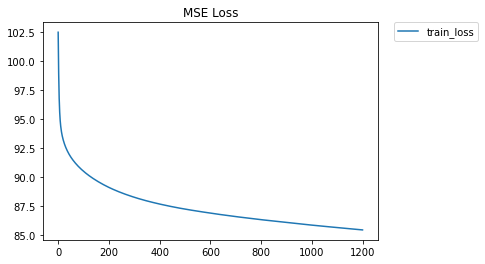

In [160]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label='train_loss')
#plt.plot(valid_losses,label='valid_loss')
plt.title('MSE Loss')
#plt.ylim(0, 100)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Testing Set Preparation/Model testing

In [161]:
x_test, y_test=util.getMultiDXY(test_region.tail(6), n_lags=2)

In [162]:
x_test

array([[[ 7.,  5., 26., 22.,  5.,  0.,  0.,  1.,  1.,  0.,  3.,  1.,
          0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [13.,  9., 20., 85.,  4.,  2.,  0.,  2.,  8.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.,  8.,  0.,  0.,  0.]],

       [[13.,  9., 20., 85.,  4.,  2.,  0.,  2.,  8.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.,  8.,  0.,  0.,  0.],
        [14.,  5.,  8., 10.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,
          0.,  0.,  0.,  0.,  3.,  0.,  2.,  0.]],

       [[14.,  5.,  8., 10.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,
          0.,  0.,  0.,  0.,  3.,  0.,  2.,  0.],
        [ 5.,  2.,  0., 23.,  3.,  2.,  5.,  1.,  0.,  0.,  2.,  0.,
          0.,  0.,  0.,  3.,  4.,  0.,  4.,  0.]],

       [[ 5.,  2.,  0., 23.,  3.,  2.,  5.,  1.,  0.,  0.,  2.,  0.,
          0.,  0.,  0.,  3.,  4.,  0.,  4.,  0.],
        [ 3.,  2.,  7., 37.,  6., 10.,  4.,  7.,  0.,  1.,  1.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]])

In [163]:
x_test[1][1]

array([14.,  5.,  8., 10.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,
        0.,  0.,  0.,  3.,  0.,  2.,  0.])

In [164]:
x_test[2][0]

array([14.,  5.,  8., 10.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,
        0.,  0.,  0.,  3.,  0.,  2.,  0.])

In [165]:
y_test

array([[14.,  5.,  8., 10.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  3.,  0.,  2.,  0.],
       [ 5.,  2.,  0., 23.,  3.,  2.,  5.,  1.,  0.,  0.,  2.,  0.,  0.,
         0.,  0.,  3.,  4.,  0.,  4.,  0.],
       [ 3.,  2.,  7., 37.,  6., 10.,  4.,  7.,  0.,  1.,  1.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 7.,  6.,  7., 49.,  6.,  0.,  1.,  2.,  2.,  2.,  6.,  0.,  1.,
         0.,  0.,  0.,  2.,  0.,  4.,  0.]])

In [166]:
x_test=x_test.reshape((x_test.shape[0], x_test.shape[1], n_features))

In [167]:
model.eval()
prediction = []
batch_size = 1
iterations =  2

for i in range(iterations):
    preds = model(torch.tensor(x_test[batch_size*i:batch_size*(i+1)]).float()).detach().numpy()
    preds = preds.reshape(1,20)
    x_test[(i+1)][1]=preds
    x_test[(i+2)][0]=preds
    prediction.append(preds)

prediction.append(x_test[-1][1])
prediction.append(model(torch.tensor(x_test[-1]).float()).detach().numpy().reshape(1,20))

In [168]:
prediction

[array([[5.0407605, 4.7688384, 4.2858334, 4.2454677, 4.841966 , 3.7707062,
         5.5843854, 4.598163 , 3.7793   , 4.5405755, 4.9672794, 3.3013988,
         4.709541 , 3.9104934, 4.0426517, 5.0492454, 4.699769 , 4.8730597,
         4.64858  , 4.61479  ]], dtype=float32),
 array([[5.3125234, 6.5584283, 6.2484336, 7.5597053, 3.9907987, 6.856809 ,
         4.8942494, 3.685001 , 4.3830457, 5.588248 , 6.2564406, 2.5953646,
         6.8184915, 4.6243825, 6.5355234, 4.8164635, 4.761172 , 5.962522 ,
         6.301336 , 3.3747532]], dtype=float32),
 array([ 3.,  2.,  7., 37.,  6., 10.,  4.,  7.,  0.,  1.,  1.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([[3.3503132, 4.6445336, 6.2714925, 5.7037635, 5.710345 , 4.298636 ,
         3.3232954, 4.7895007, 5.1497107, 4.953611 , 5.5597715, 4.788865 ,
         5.0105243, 6.285558 , 5.731327 , 4.547596 , 4.3346972, 6.1700587,
         5.5527453, 4.8779283]], dtype=float32)]

In [169]:
len(prediction)

4

In [170]:
from sklearn.metrics import mean_squared_error

In [158]:
for i in range(len(prediction)):
    y_true = y_test[i]
    y_pred = prediction[i].reshape(20)
    print(mean_squared_error(y_true, y_pred))

19.79518166662896
27.313255002230495
55.54677395614904
92.54694801805297


In [171]:
for i in range(len(prediction)):
    y_true = y_test[i]
    y_pred = prediction[i].reshape(20)
    print(mean_squared_error(y_true, y_pred))

19.569403444469256
28.60557813639067
0.0
107.13059789990511
